In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import io
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv2D, MaxPooling2D, Dense, Conv1D, Dropout
from keras.layers import MaxPooling1D, Flatten, Embedding, LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
import spacy
import nltk
import en_core_web_md
from tensorflow import keras

Using TensorFlow backend.


# Will grade my fake reviews
and export the results to a csv and pickle

In [2]:
first_text_dir = 'gpt2_generated_text/ign_345M_1000_epochs/'
small_training_files = [first_text_dir + x for x in os.listdir(first_text_dir)]
# print(small_training_files)

In [3]:
temp_dict = {}

for path in small_training_files:
    i = 0
    temp_file = open(path, mode='r', encoding='utf-8')
    file_text = temp_file.read()
    text_splits = file_text.split('====================')
    text_splits.pop()
    file_name = path.split('sample_')[1].split('.tx')[0]

    for text in text_splits:
        dict_key = file_name + str(i)
        # could include the model that I'm using as well
        temp_dict[dict_key] = {'review': file_name, 'review_text': text} 
        
        i += 1

fake_text_df = pd.DataFrame(temp_dict)
fake_text_df = fake_text_df.T

In [4]:
print(fake_text_df.shape)
fake_text_df.head()

(2949, 2)


,review,review_text
Alpha Protocol Review0,Alpha Protocol Review,"Alpha Protocol Review #1, #3 and #5. Another d..."
Alpha Protocol Review1,Alpha Protocol Review,\nAlpha Protocol Review Path: Working Selectio...
Alpha Protocol Review2,Alpha Protocol Review,\nAlpha Protocol Review: Pentacle X3500/3550 M...
Alpha Protocol Review3,Alpha Protocol Review,\nAlpha Protocol Review Papers 2016-09-01 [Arc...
Alpha Protocol Review4,Alpha Protocol Review,\nAlpha Protocol Review\n\nWho voted on it? In...


# load ign data to mimic inputs for models

In [5]:
ign_df = pd.read_pickle('ign_data/ign_data_pass_three.pkl')

ign_df = ign_df.loc[ign_df['review_score']!='null']
ign_df.reset_index(drop=True)

print(ign_df.shape)
ign_df.head()

(11072, 19)


,links,rough_review_body,cleaned_review_body,review_summary_rough,review_score,tags,categories,modified_date,published_date,author_name,tag_list,categories_list,review_title,review_body_corpus,review_score_float,number_character_review,number_words_review,polarity,subjectivity
1,https://www.ign.com/articles/2011/07/19/warham...,"\u003csection class=\""article-page\""\u003e\u00...",'Warhammer 40K: Kill Team might be unfortun...,"""And \""also-ran\"" hangs all over Warhammer 40K...",6.5,":[""review"",""blogroll"",""event-essentials"",""hot""...",":[""ign"",""ps3"",""xbox-360"",""xbox-live""],",2011-10-18T05:59:32+0000,2011-07-19T19:47:00+0000,"""Arthur Gies""","[review, blogroll, event-essentials, hot, lega...","[ign, ps3, xbox-360, xbox-live, ]","""Warhammer 40K: Kill Team Review""",warhammer 40k kill team might be unfortunat...,6.5,3705,642,0.062923,0.433371
2,https://www.ign.com/articles/2011/07/20/call-o...,"\u003csection class=\""article-page\""\u003eThe ...",The Call of Juarez franchise always intereste...,"""Call of Juarez: The Cartel is a poor change o...",4.5,":[""review"",""blogroll"",""call-of-juarez-the-cart...",":[""ign"",""pc"",""ps3"",""xbox-360""],",2011-10-18T06:02:02+0000,2011-07-20T00:14:00+0000,"""Anthony Gallegos""","[review, blogroll, call-of-juarez-the-cartel, ...","[ign, pc, ps3, xbox-360, ]","""Call of Juarez: The Cartel Review""",the call of juarez franchise always intereste...,4.5,3770,648,-0.016471,0.457898
3,https://www.ign.com/articles/2011/07/20/captai...,"\u003csection class=\""article-page\""\u003eThe ...",The majority of movie games are just awful. S...,"""Captain America: Super Soldier is a mediocre ...",5.5,":[""review"",""blogroll"",""legacy"",""wii"",""games"",""...",":[""ign"",""wii""],",2011-10-18T06:02:20+0000,2011-07-20T00:43:00+0000,"""Audrey Drake""","[review, blogroll, legacy, wii, games, captain...","[ign, wii, ]","""Captain America: Super Soldier Wii Review""",the majority of movie games are just awful st...,5.5,2675,474,-0.003842,0.544458
4,https://www.ign.com/articles/2011/07/20/quiz-c...,"\u003csection class=\""article-page\""\u003e\u00...","'Quiz Climber, from Buzz! developer 'Rele...","""Ultimately, Quiz Climber is just a little too...",6.5,":[""review"",""blogroll"",""games"",""legacy"",""wirele...",":[""ign"",""wireless""],",2011-10-18T06:07:06+0000,2011-07-20T21:44:00+0000,"""Justin Davis""","[review, blogroll, games, legacy, wireless, qu...","[ign, wireless, ]","""Quiz Climber Review""",quiz climber from buzz developer relentle...,6.5,1854,349,0.091160,0.600205
5,https://www.ign.com/articles/2011/07/20/limbo-...,"\u003csection class=\""article-page\""\u003eVide...",Video games are an art form made up of visual...,"""Limbo is an incredible achievement. Very few ...",9,":[""review"",""games"",""legacy"",""limbo"",""platforme...",":[""pc"",""ps3""],",2011-10-18T06:07:21+0000,2011-07-20T22:29:00+0000,"""Daemon Hatfield""","[review, games, legacy, limbo, platformer, pla...","[pc, ps3, ]","""Limbo Review""",video games are an art form made up of visual...,9.0,2938,527,0.096551,0.525587


In [6]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'), 
                             lowercase=True, min_df=3, max_df=0.9, max_features=5000)

test_size = 0.2

ign_data = ign_df['cleaned_review_body'].values
ign_scores = ign_df['review_score_float'].values 
ign_standard_values = ign_scores/10.0

data_train, data_validation, target_train, target_validation = train_test_split(ign_data, 
                                                                                ign_standard_values, 
                                                                                test_size=test_size, 
                                                                                random_state=42)

In [7]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'), 
                             lowercase=True, min_df=3, max_df=0.9, max_features=5000)
data_train_cv = vectorizer.fit_transform(data_train)
data_valid_cv = vectorizer.transform(data_validation)

In [8]:
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()

# print(len(vectorizer.get_feature_names()))

def to_sequence(tokenizer, preprocessor, index, text):
    
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    
    return indexes

print(to_sequence(tokenize, preprocess, word2idx, 'This is an important test!'))

[2218, 4437]


In [9]:
data_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in data_train]
data_valid_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in data_validation]

# padding sequences
MAX_SEQ_LENGTH = len(max(data_train_sequences, key=len))
if len(max(data_valid_sequences, key=len)) > MAX_SEQ_LENGTH:
    MAX_SEQ_LENGTH = len(max(data_valid_sequences, key=len))
    
N_FEATURES = len(vectorizer.get_feature_names())

# a correction I'm putting in, because MAX Length changes otherwise based on training (need to change logic on this)
MAX_SEQ_LENGTH = 2704 # whoops, forgot to get rid of that

data_train_sequences = pad_sequences(data_train_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)
data_valid_sequences = pad_sequences(data_valid_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)

print(data_train_sequences[0])

[5000 5000 5000 ... 2851  481  876]


# Make sequences for the fake data

In [10]:
fake_reviews = fake_text_df['review_text'].values
# fake_reviews_cv = vectorizer.transform(fake_reviews)
# print(fake_reviews[0])
fake_reviews_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in fake_reviews]
fake_reviews_sequences = pad_sequences(fake_reviews_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)

# Load in model that I want to score with

In [11]:
loaded_cnn_model = keras.models.load_model('scoring_models/cnn_model_06_10.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
# getting scores
fake_scores = loaded_cnn_model.predict(fake_reviews_sequences)

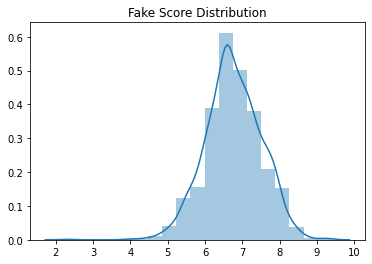

In [19]:
# print(fake_scores)
# sns.distplot(fake_scores)

better_fake_scores = [round(x*10, 1) for x in fake_scores[:,0]]
# print(better_fake_scores)

sns.distplot(better_fake_scores, bins=19)
plt.title('Fake Score Distribution')
plt.show()

In [22]:
fake_text_df['scores'] = better_fake_scores
fake_text_df.head()

,review,review_text,scores
Alpha Protocol Review0,Alpha Protocol Review,"Alpha Protocol Review #1, #3 and #5. Another d...",7.5
Alpha Protocol Review1,Alpha Protocol Review,\nAlpha Protocol Review Path: Working Selectio...,6.9
Alpha Protocol Review2,Alpha Protocol Review,\nAlpha Protocol Review: Pentacle X3500/3550 M...,5.8
Alpha Protocol Review3,Alpha Protocol Review,\nAlpha Protocol Review Papers 2016-09-01 [Arc...,6.9
Alpha Protocol Review4,Alpha Protocol Review,\nAlpha Protocol Review\n\nWho voted on it? In...,6.1


In [23]:
# save the fake data
fake_text_df.to_pickle('ign_data/fake_data_01.pkl')
fake_text_df.to_csv('ign_data/fake_data_01.csv')